# Define gene signatures and visualize tree on tSNE
- define robust gene signatures defining each cluster beyond the decision tree rules
- measure signature similarity across experiments
- find the appropriate tSNE parameters
overlay tree hierarchy on tSNE annotated by (1) cluster membership (2) decision tree
genes (3) robust cluster gene signatures activation
- generating additional figures for the manuscript (heatmaps, illustrations etc)

## pseudocode for robust gene signature


DE_childrenNodes

**Input**
- **X**: $n$ genes $\times m$ cell count matrix of gene expression
- **child_node_1_idx**: a $m \times 1$ logical vector that indicates where the cells for children node 1 are
- **child_node_2_idx**: a $m \times 1$ logical vector that indicates where the cells for children node 2 are
- **q_thresh**: a positive real number that gives cutoff of q value of DE analysis
- **FC_thresh**: a positive real number that defines the cutoff of fold change the DE analysis

**Output**
- **Y**: $l \times 2$ matrix that contains $l$ differentially expressed genes between the two child nodes of corresponding q value and FC value

In [59]:
source('../../R/gene_signature.R')

In [28]:
library(limma)
library(qvalue)

## Test on the dataset

In [52]:
n_genes = 100
n_cells = 50
set.seed(1)
X = matrix(sample(1:100, n_genes * n_cells, replace=T), nrow=n_genes) # n genes x m cells
rownames(X) = paste0('c', seq(nrow(X)))
child_node_1_idx = sample(c(T, F), n_cells, replace=T)
child_node_2_idx = !child_node_1_idx
q_thresh = 0.5
FC_thresh = 1.5
DE_childrenNodes(X, child_node_1_idx, child_node_2_idx, q_thresh, FC_thresh)

,log2FoldChange,padj
c100,0.5892649,0.9969559


In [60]:
DE_childrenNodes.limma(X, child_node_1_idx, child_node_2_idx, q_thresh, FC_thresh)

,logFC,adj.P.Val
c91,19.73052,0.4213694
c32,19.70130,0.4213694
c92,19.38312,0.4213694
c100,19.18506,0.4213694
c56,18.16558,0.4213694


DE_twoExps(X, child_node_1_idx, child_node_2_idx, q_thresh, FC_thresh,
           X, child_node_1_idx, child_node_2_idx, q_thresh, FC_thresh)

In [ ]:
t3.hierarchy.data = read.table('../../data/treeHierarchy/t3.expression.cutree.csv',
                     row.names=1)
hierarchy = t3.hierarchy.data[,c('X2', 'X4', 'X8', 'X16')]

In [63]:
t3.data = t3.hierarchy.data[,!(colnames(t3.hierarchy.data) %in% c('X2', 'X4', 'X8', 'X16'))]
t3.data.arranged = t(t3.data)

In [64]:
head(colnames(t3.data.arranged))
head(rownames(t3.data.arranged))

[1] "AAACCTGGTAAATACG.1" "AAACCTGGTGTGCCTG.1" "AAACCTGTCAGCTCTC.1"
[4] "AAACGGGAGGGCTTGA.1" "AAACGGGAGTATCGAA.1" "AAACGGGCAGTTCCCT.1"

[1] "TSPAN6"   "TNMD"     "DPM1"     "SCYL3"    "C1orf112" "FGR"

In [70]:
'CD8A' %in% rownames(t3.data.arranged)

[1] TRUE

In [66]:
CD4.idx = t3.data.arranged['CD4', ] > 0
CD8alpha.idx = t3.data.arranged['CD8A',] > 0
subset_cells.idx = (CD4.idx | CD8alpha.idx)
t3.data.arranged = t3.data.arranged[,subset_cells]

In [78]:
table(CD4.idx, CD8alpha.idx)

       CD8alpha.idx
CD4.idx FALSE TRUE
  FALSE  2305  700
  TRUE    416   42

## t4 dataset

In [207]:
folder.path = '../../data/DESeq/t4/res.0.1/'
cluster.names = list.files(folder.path)
cluster.num = sapply(cluster.names, function(x) str_match(x, '[0-9]'))

In [251]:
genes.top10 = c()
for (i in seq(length(cluster.num))) {
    genes = read.csv(paste0(folder.path, cluster.names[i])) %>%
      filter(p_val_adj < 0.05) %>% arrange(desc(avg_logFC)) %>% .[1:10,'X'] %>% as.character
    genes.top10 = rbind(genes.top10, data.frame(gene=genes, i=i-1))
}

In [253]:
genes.top10 %<>% group_by(gene) %>% top_n(1) %>% arrange(i) %>% ungroup %>% mutate(i=as.character(i), gene=as.character(gene))

Selecting by i


## Load the original data matrix

Parsed with column specification:
cols(
  .default = col_integer(),
  external_gene_name = col_character()
)
See spec(...) for full column specifications.


In [115]:
head(scrnaseq_data, n=2)

external_gene_name,AAACCTGAGTGAAGAG-1,AAACCTGCAAACCTAC-1,AAACCTGCACTGCCAG-1,AAACCTGCAGGTGCCT-1,AAACCTGCAGTAACGG-1,AAACCTGGTGCCTGCA-1,AAACCTGTCGGCATCG-1,AAACGGGAGAAGGTGA-1,AAACGGGAGACAAAGG-1,⋯,TTTGTCACACCCAGTG-1,TTTGTCACAGATGAGC-1,TTTGTCACATTACGAC-1,TTTGTCAGTAAATGTG-1,TTTGTCAGTAATCACC-1,TTTGTCAGTAGAGCTG-1,TTTGTCAGTAGCGTGA-1,TTTGTCAGTCCCTTGT-1,TTTGTCAGTCGATTGT-1,TTTGTCATCACAATGC-1
TSPAN6,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TNMD,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


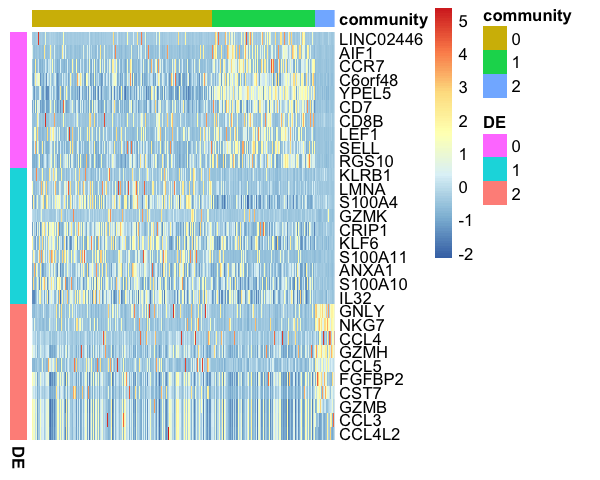

In [328]:
heatmap.data = scrnaseq_data %>%
  filter(external_gene_name %in% genes.top10$gene)
heatmap.genes = heatmap.data[,1]
heatmap.data = heatmap.data[,-1] %>% data.matrix
rownames(heatmap.data) = unlist(heatmap.genes)
heatmap_rows = rownames(heatmap.data)
heatmap_cols = colnames(heatmap.data)

for (i in seq(10)) {
    heatmap.data = apply(heatmap.data, 2, scale)
    heatmap.data = t(apply(heatmap.data, 1, scale))
}

rownames(heatmap.data) = heatmap_rows
colnames(heatmap.data) = heatmap_cols

cell_clusters = read.table('../../data/DESeq/t4.Seurat.cluster.csv', sep=',', header=T)
colnames(cell_clusters)[1] = 'cell'
arranged_cells = cell_clusters %>% select(c(cell, res.0.1)) %>% arrange(res.0.1) %>% mutate(res.0.1 = as.character(res.0.1))
col_annot = data.frame(community=as.character(arranged_cells$res.0.1) %>% unlist)
rownames(col_annot) = arranged_cells$cell %>% unlist
row_annot = data.frame(DE=genes.top10$i)
rownames(row_annot) = genes.top10$gene

heatmap.data1 = heatmap.data[unlist(genes.top10$gene), unlist(arranged_cells$cell)]
options(repr.plot.width=5, repr.plot.height=4)
pheatmap(heatmap.data1,
        show_rownames = T,
        show_colnames = F,
        cluster_cols=F,
        cluster_rows=F,
        annotation_col = col_annot,
        annotation_row = row_annot
        )

In [331]:
unique(arranged_cells$res.0.1)

[1] "0" "1" "2"

In [335]:
median_data = data.frame(t(heatmap.data1)) 
plot_median_data = data.frame()
for(i in unique(arranged_cells$res.0.1)) {
    cells = arranged_cells %>% filter(res.0.1 == i) %>% select(cell) %>% unlist
    print(intersect(cells, rownames(median_data)) %>% length)
    plot_median_data = rbind(plot_median_data, apply(median_data[cells,], 2, function(x) median(x, na.rm=T)))
}

[1] 2700
[1] 1541
[1] 297


In [337]:
rownames(plot_median_data) = unique(arranged_cells$res.0.1)

In [339]:
plot_median_data

,X.0.350462352439168,X.0.444888874365589,X.0.456914049641225,X.0.281560937104065,X.0.305115790775565,X.0.324621118156557,X.0.409344634062818,X.0.485913027575264,X.0.450419919601044,X.0.390994148448545,⋯,X.0.362811586924509,X.0.400429622502264,X.0.289432990842136,X.0.235054387947343,X.0.352475769497206,X.0.166204541713962,X.0.264838854582781,X.0.156334665095195,X.0.163786844129048,X.0.175558416690273
0,-0.3504624,-0.4448889,-0.4569140,-0.2815609,-0.3051158,-0.3246211,-0.4093446,-0.4859130,-0.4504199,-0.3909941,⋯,-0.3628116,-0.4004296,-0.2894330,-0.2350544,-0.3524758,-0.1662045,-0.2648389,-0.1563347,-0.1637868,-0.1755584
1,-0.3475306,-0.4572650,-0.4771541,-0.2806819,-0.3593778,-0.3161327,-0.4089083,-0.4932208,-0.4301425,-0.4168496,⋯,-0.3623051,-0.4035761,-0.2634460,-0.2226876,-0.3450227,-0.1530300,-0.2483533,-0.1236835,-0.1478526,-0.1575792
2,-0.3430608,-0.4527737,-0.4635333,-0.3230009,-0.3741262,-0.3413917,-0.4104589,-0.4856736,-0.4513257,-0.4032563,⋯,-0.3487057,-0.3934338,-0.2916241,-0.2577868,-0.3242607,-0.1481614,-0.2571707,-0.1389609,-0.1724206,-0.1623744


In [340]:
head(median_data)

AIF1,CCR7,C6orf48,YPEL5,CD7,CD8B,LEF1,SELL,RGS10,KLRB1,⋯,GNLY,NKG7,CCL4,GZMH,CCL5,FGFBP2,CST7,GZMB,CCL3,CCL4L2
-0.6330868,-0.8673052,-0.2333128,-0.4492309,-0.07896719,-0.6406836,1.5390911,0.5209203,0.6681235,-0.6867123,⋯,-0.7232557,2.4261842,-0.1323472,0.27552477,-0.7907973,0.77825350,0.06976457,0.98522940,1.0144516,0.9528596
1.2155750,0.6798089,1.8518528,-0.7198469,-0.56207360,-0.3393596,1.3091197,0.6393819,-0.5613630,-0.3239275,⋯,-0.2818053,-0.3515990,-0.6212973,-0.73416971,-0.2654353,-0.82595947,-0.65056351,-0.84504878,-0.8835417,-0.8876825
-0.5134831,-0.7069391,0.5752895,-0.8168768,-0.91366171,-0.4583528,-0.5993772,-0.7389259,-0.8286561,3.8574173,⋯,-0.3858113,-0.4238083,-0.1129347,-0.09779681,2.2018765,0.01157554,-0.26993050,0.07648997,0.1347191,0.1323470
-0.6087387,-0.8464318,1.0707963,-1.0735042,-0.32658620,-0.5856106,-0.6983514,-0.8903117,-0.9824530,2.3389637,⋯,-0.6110695,-0.6429081,-0.1549155,0.09967593,-0.6940111,0.47134429,-0.09246389,0.63661115,0.6775264,0.6349148
-0.4118639,-0.5086522,-0.5034316,-0.4626366,-0.17099416,-0.3351928,-0.4809928,-0.5257199,-0.2461380,1.7083838,⋯,4.3818362,1.0450441,-0.3279360,-0.57421797,0.2010912,-0.72515090,-0.61696129,-0.76089774,-0.7030764,-0.6724188
-0.4853029,-0.6272416,0.3318504,-1.0087974,1.67936542,1.4878411,-0.5554227,1.0317663,3.1661896,-0.4531463,⋯,-0.4042434,-0.4393282,-0.3694662,-0.29706096,-0.4367311,-0.18833893,-0.34466412,-0.13133408,-0.1421297,-0.1635569


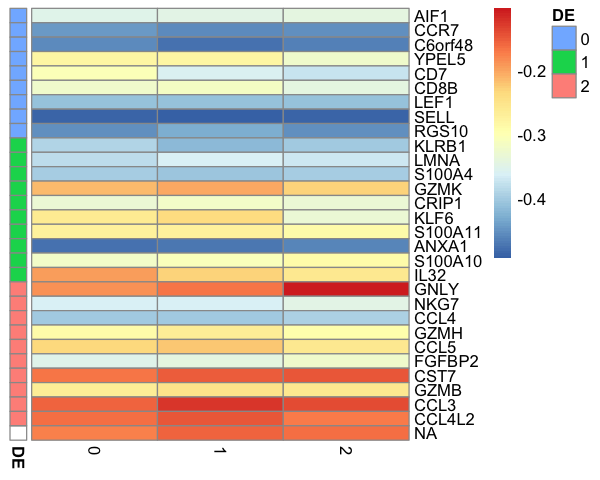

In [342]:
colnames(plot_median_data) = colnames(median_data)

t(plot_median_data) %>% pheatmap(.,
                                 
        show_rownames = T,
        show_colnames = T,
        cluster_cols=F,
        cluster_rows=F,
        annotation_row = row_annot)

 ## t3 data set